In [30]:
import pandas as pd
import json 
import gzip
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pydotplus
#import graphviz
from sklearn.feature_extraction.text import TfidfVectorizer



# Amazon Review Classification

For this project I selected the office products dataset from Amazon, consisting of 53,258 reviews of various office products purchased over the years from Amazon.

In [31]:
#opening the json file
import gzip
import pandas as pd
with gzip.open('reviews_Office_Products_5.json.gz', 'rb') as data_file:
    df = pd.read_json(data_file.read().decode("utf-8"),lines=True)

In [32]:
#dropping missing data and checking the shape of the data
df = df.dropna()

print(df.head())
print(df.shape)

         asin helpful  overall  \
0  B00000JBLH  [3, 4]        5   
1  B00000JBLH  [7, 9]        5   
2  B00000JBLH  [3, 3]        2   
3  B00000JBLH  [7, 8]        5   
4  B00000JBLH  [0, 0]        5   

                                          reviewText   reviewTime  \
0  I bought my first HP12C in about 1984 or so, a...   09 3, 2004   
1  WHY THIS BELATED REVIEW? I feel very obliged t...  12 15, 2007   
2  I have an HP 48GX that has been kicking for mo...   01 1, 2011   
3  I've started doing more finance stuff recently...  04 19, 2006   
4  For simple calculations and discounted cash fl...   08 4, 2013   

       reviewerID         reviewerName  \
0  A32T2H8150OJLU                  ARH   
1  A3MAFS04ZABRGO     Let it Be "Alan"   
2  A1F1A0QQP2XVH5               Mark B   
3   A49R5DBXXQDE5         R. D Johnson   
4  A2XRMQA6PJ5ZJ8  Roger J. Buffington   

                                             summary  unixReviewTime  
0            A solid performer, and long time friend    

In [33]:
#viewing column names
df.columns

Index(['asin', 'helpful', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'summary', 'unixReviewTime'],
      dtype='object')

In [34]:
#viewing column names
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52799 entries, 0 to 53257
Data columns (total 9 columns):
asin              52799 non-null object
helpful           52799 non-null object
overall           52799 non-null int64
reviewText        52799 non-null object
reviewTime        52799 non-null object
reviewerID        52799 non-null object
reviewerName      52799 non-null object
summary           52799 non-null object
unixReviewTime    52799 non-null int64
dtypes: int64(2), object(7)
memory usage: 4.0+ MB


Most of the data is in object or string format.

In [35]:
#creating our dependent variable by mapping the variable "overall" from ordinal to a binary class label.
df['Sentiment'] = df['overall'].map({1:'Negative', 2:'Negative', 3:'Negative', 4:'Positive', 5:'Positive'}) 

In [36]:
#viewing the value counts of each class in dependent variable
df['Sentiment'].value_counts()

Positive    44927
Negative     7872
Name: Sentiment, dtype: int64

We can see above that there is significant class imbalance within our dependent variable "Sentiment".  I will attempt to remedy this next by undersampling according to the number of observations in the Negative class label.

In [37]:
# Resampling our data

# Class count
count_Sentiment_pos, count_Sentiment_neg = df.Sentiment.value_counts()
print(count_Sentiment_neg)
print(count_Sentiment_pos)
# Divide by class
df_Sentiment_neg = df[df['Sentiment'] == 'Negative']
df_Sentiment_pos = df[df['Sentiment'] == 'Positive']

7872
44927


Random under-sampling:
Positive    7872
Negative    7872
Name: Sentiment, dtype: int64


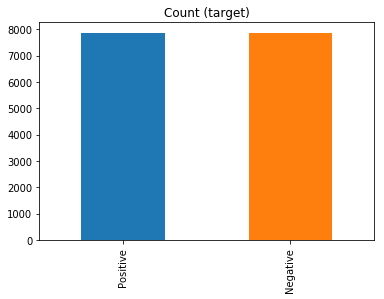

In [38]:
#extract the observations with class zero, equal to the number of obervations equal
df_Sentiment_pos_under = df_Sentiment_pos.sample(count_Sentiment_neg)

#create a new dataframe with the same number of values for our two classes
new_df = pd.concat([df_Sentiment_pos_under, df_Sentiment_neg], axis=0)

print('Random under-sampling:')
print(new_df.Sentiment.value_counts())

new_df.Sentiment.value_counts().plot(kind='bar', title='Count (target)')

The data is now balanced regarding the class values in our dependent variable.

In [39]:
#rechecking the columns in the new dataframe with the balanced classes.
new_df.columns

Index(['asin', 'helpful', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'summary', 'unixReviewTime', 'Sentiment'],
      dtype='object')

In [48]:
#checking the shape of the new dataframe
new_df.shape

(15744, 10)

Next I will apply tf-idf and convert the text in our 'reviewText' variable into numeric vectors, that will basically translate the text in this column from human-readable language to something a computer, and more importantly our machine learning models, can understand.

In [43]:
#create corpus
corpus_var = new_df['reviewText']

In [44]:
#initiate and fit our tfidf vector

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
corpus_var_tfidf=vectorizer.fit_transform(corpus_var)
print("Number of features: %d" % corpus_var_tfidf.get_shape()[1])

Number of features: 16478


In [49]:
#assign dependent, or class, variable
Y = new_df['Sentiment']

In [46]:
#splitting into training and test sets
#X_train_tfidf, X_test_tfidf= train_test_split(corpus_var_tfidf, test_size=0.4, random_state=0)


In [50]:
#split the data

#splitting the data into train and test groups.

train_X, test_X, train_Y, test_Y = train_test_split(corpus_var_tfidf, Y, test_size=.4, random_state=200)
print(test_X.shape)
print(test_Y.shape)

(6298, 16478)
(6298,)


# Naive Bayes:

In [53]:
# Instantiate and train our naive bayes model
Mnb = MultinomialNB()

#set start time
start_time = datetime.datetime.now()

# Fit our model to the data.
Mnb.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_bayes = Mnb.predict(test_X)

#get accuracy score from our model
print('Accuracy score for decision tree Model: ' + str(metrics.accuracy_score(test_Y, y_pred_bayes)))

#Run score
print('Score: ', Mnb.score(test_X, test_Y))

#calculate end time
end_time = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time - start_time))
print()

#Use cross validation to gauge the accuracy of our model
Nbayes_cvs = cross_val_score(Mnb, corpus_var_tfidf, Y, cv=10, scoring='accuracy')
print(Nbayes_cvs)
print('Average cross validated score from our Naive Bayes model is: ' + str(np.mean(Nbayes_cvs)))

Accuracy score for decision tree Model: 0.7370593839314068
Score:  0.7370593839314068

Duration: 0:00:00.065900

[0.69733503 0.71510152 0.72172808 0.63532402 0.67090216 0.72681067
 0.67662008 0.70711563 0.71728081 0.6931385 ]
Average cross validated score from our Naive Bayes model is: 0.6961356497397428


Naive Bayes gave a decent score of about 74%.  The inner workings of the Naive Bayes algorithm is very similar to what I did here with tf-idf, by representing the review text with numeric vectors that became the inputs to our model.  Recall that with Naive Bayes, the Bayes theorem is extended to when x, the input variables, becomes a vector of conditions.  Then Naive Bayes returns the class label, Y, that was most likely to give us the observed x variables (or conditions), based on their bayesian probabilites.

Similarly the numeric vectors created with tf-idf became the inputs to our model, and made it possible for our model to differentiate between different review texts, by giving different weights to different words.  Through this, the algorithm was successfully able to learn which vectors matched which corresponding class label. 



In [54]:
#confusion matrix for naive bayes
from sklearn.metrics import confusion_matrix
confusion_matrix(test_Y, y_pred_bayes)

array([[2441,  660],
       [ 996, 2201]], dtype=int64)

In [55]:
#perform classification report of naive bayes model
class_names = ['Negative', 'Positive']
bayes_report = classification_report(test_Y, y_pred_bayes, target_names=class_names)
print(bayes_report)

              precision    recall  f1-score   support

    Negative       0.71      0.79      0.75      3101
    Positive       0.77      0.69      0.73      3197

   micro avg       0.74      0.74      0.74      6298
   macro avg       0.74      0.74      0.74      6298
weighted avg       0.74      0.74      0.74      6298



Judging from the recall ratings in the above classification report, we can say that the Naive Bayes classifer model was overall alittle better at catching and identifying those reviews with a negative sentiment.  The recall rating suggests that 79% of the total negatives were identified vs. 69% of the total positives were identified.  However, the precision rating for the positives was alittle higher at 77% vs. 71% for the Negatives, suggesting that of all the reviews predicted by the Naive Bayes model to be positive or negative, the naive bayes model was alittle better at accurately predicting the positives.  This is also confirmed by confusion matrix above, which shows a lower number of false positives (660) compared to the number of false negatives (996).

In [56]:
# predict probabilities
probs_bayes = Mnb.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_bayes = probs_bayes[:, 1]
# calculate AUC
bayes_auc = roc_auc_score(test_Y, probs_bayes)
print('AUC Score: %.3f' % bayes_auc)
# calculate roc curve
#fpr_bayes, tpr_bayes, thresholds = roc_curve(test_Y, probs_bayes)
# plot no skill
#plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
#plt.plot(fpr_bayes, tpr_bayes, marker='.')
# show the plot
#plt.show()

AUC Score: 0.816


## Decision Tree

In [82]:
# perform grid search to find the optimal parameters for our decision tree model, but this time using full data
dtree = tree.DecisionTreeClassifier(random_state=76)
tree_param_grid = {'max_depth':[200,300], 'min_samples_split':[12,15,18,22], 'max_features':[200,350], 
                   'criterion':['entropy', 'gini']}
dtree_grid = GridSearchCV(dtree, tree_param_grid, cv=5, verbose=3)
dtree_grid.fit(train_X, train_Y)
print('Best parameters for decision tree: ', dtree_grid.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] criterion=entropy, max_depth=200, max_features=200, min_samples_split=12 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=entropy, max_depth=200, max_features=200, min_samples_split=12, score=0.6174603174603175, total=   0.4s
[CV] criterion=entropy, max_depth=200, max_features=200, min_samples_split=12 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  criterion=entropy, max_depth=200, max_features=200, min_samples_split=12, score=0.5971413446267867, total=   0.3s
[CV] criterion=entropy, max_depth=200, max_features=200, min_samples_split=12 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  criterion=entropy, max_depth=200, max_features=200, min_samples_split=12, score=0.606140815246162, total=   0.3s
[CV] criterion=entropy, max_depth=200, max_features=200, min_samples_split=12 
[CV]  criterion=entropy, max_depth=200, max_features=200, min_samples_split=12, score=0.5796717840127051, total=   0.3s
[CV] criterion=entropy, max_depth=200, max_features=200, min_samples_split=12 
[CV]  criterion=entropy, max_depth=200, max_features=200, min_samples_split=12, score=0.6114346214928533, total=   0.3s
[CV] criterion=entropy, max_depth=200, max_features=200, min_samples_split=15 
[CV]  criterion=entropy, max_depth=200, max_features=200, min_samples_split=15, score=0.6216931216931217, total=   0.3s
[CV] criterion=entropy, max_depth=200, max_features=200, min_samples_split=15 
[CV]  criterion=entropy, max_depth=200, max_features=200, min_samples_split=15, score=0.6087877183695076, total=   0.3s
[CV] criterion=entropy, max_depth=200, max_features=200, min_samples_split=15 
[CV]  

[CV]  criterion=entropy, max_depth=300, max_features=200, min_samples_split=12, score=0.5971413446267867, total=   0.3s
[CV] criterion=entropy, max_depth=300, max_features=200, min_samples_split=15 
[CV]  criterion=entropy, max_depth=300, max_features=200, min_samples_split=15, score=0.6026455026455027, total=   0.3s
[CV] criterion=entropy, max_depth=300, max_features=200, min_samples_split=15 
[CV]  criterion=entropy, max_depth=300, max_features=200, min_samples_split=15, score=0.6156696664902065, total=   0.3s
[CV] criterion=entropy, max_depth=300, max_features=200, min_samples_split=15 
[CV]  criterion=entropy, max_depth=300, max_features=200, min_samples_split=15, score=0.6045526733721546, total=   0.3s
[CV] criterion=entropy, max_depth=300, max_features=200, min_samples_split=15 
[CV]  criterion=entropy, max_depth=300, max_features=200, min_samples_split=15, score=0.594494441503441, total=   0.3s
[CV] criterion=entropy, max_depth=300, max_features=200, min_samples_split=15 
[CV]  

[CV]  criterion=gini, max_depth=200, max_features=200, min_samples_split=15, score=0.587083112758073, total=   0.3s
[CV] criterion=gini, max_depth=200, max_features=200, min_samples_split=15 
[CV]  criterion=gini, max_depth=200, max_features=200, min_samples_split=15, score=0.6045526733721546, total=   0.3s
[CV] criterion=gini, max_depth=200, max_features=200, min_samples_split=15 
[CV]  criterion=gini, max_depth=200, max_features=200, min_samples_split=15, score=0.6013763896241398, total=   0.3s
[CV] criterion=gini, max_depth=200, max_features=200, min_samples_split=15 
[CV]  criterion=gini, max_depth=200, max_features=200, min_samples_split=15, score=0.6103758602435151, total=   0.3s
[CV] criterion=gini, max_depth=200, max_features=200, min_samples_split=18 
[CV]  criterion=gini, max_depth=200, max_features=200, min_samples_split=18, score=0.608994708994709, total=   0.3s
[CV] criterion=gini, max_depth=200, max_features=200, min_samples_split=18 
[CV]  criterion=gini, max_depth=200, 

[CV]  criterion=gini, max_depth=300, max_features=200, min_samples_split=15, score=0.5992588671254632, total=   0.3s
[CV] criterion=gini, max_depth=300, max_features=200, min_samples_split=18 
[CV]  criterion=gini, max_depth=300, max_features=200, min_samples_split=18, score=0.6010582010582011, total=   0.3s
[CV] criterion=gini, max_depth=300, max_features=200, min_samples_split=18 
[CV]  criterion=gini, max_depth=300, max_features=200, min_samples_split=18, score=0.5881418740074114, total=   0.3s
[CV] criterion=gini, max_depth=300, max_features=200, min_samples_split=18 
[CV]  criterion=gini, max_depth=300, max_features=200, min_samples_split=18, score=0.6019057702488089, total=   0.2s
[CV] criterion=gini, max_depth=300, max_features=200, min_samples_split=18 
[CV]  criterion=gini, max_depth=300, max_features=200, min_samples_split=18, score=0.5992588671254632, total=   0.3s
[CV] criterion=gini, max_depth=300, max_features=200, min_samples_split=18 
[CV]  criterion=gini, max_depth=300

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.4min finished


Best parameters for decision tree:  {'criterion': 'entropy', 'max_depth': 200, 'max_features': 200, 'min_samples_split': 15}


In [83]:
print('decision tree best score from Gridsearchcv: ', dtree_grid.best_score_)

decision tree best score from Gridsearchcv:  0.612957865763286


In [84]:
# Initialize and train our tree using full data
decision_tree = tree.DecisionTreeClassifier(
    criterion='gini',
    max_features=200,
    max_depth=200,
    min_samples_split=15,
    random_state = 399
)

#set start time
start_time2 = datetime.datetime.now()

#train our tree
decision_tree.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_dtree = decision_tree.predict(test_X)

#Run score
print('Score: ', decision_tree.score(test_X, test_Y))

#get accuracy score from our model
print('Accuracy score for decision tree Model: ' + str(metrics.accuracy_score(test_Y, y_pred_dtree)))

#calculate end time
end_time2 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time2 - start_time2))
print()

#get accuracy score of decision tree
tree_score = cross_val_score(decision_tree, corpus_var_tfidf, Y, cv=10, scoring='accuracy')
print(tree_score)
print('Average cross validated score from our decision tree model is: ' + str(np.mean(tree_score)))

Score:  0.6146395681168625
Accuracy score for decision tree Model: 0.6146395681168625

Duration: 0:00:00.471218

[0.58185279 0.60152284 0.59911055 0.56670902 0.59847522 0.58132147
 0.59656925 0.64104193 0.61245235 0.60800508]
Average cross validated score from our decision tree model is: 0.5987060513806204


In [86]:
#confusion matrix for decision tree built on full data
confusion_matrix(test_Y, y_pred_dtree)

array([[2026, 1075],
       [1352, 1845]], dtype=int64)

In [87]:
#perform classification report of decision tree model with full data
class_names = ['Negative', 'Positive']
tree_report_full = classification_report(test_Y, y_pred_dtree, target_names=class_names)
print(tree_report_full)

              precision    recall  f1-score   support

    Negative       0.60      0.65      0.63      3101
    Positive       0.63      0.58      0.60      3197

   micro avg       0.61      0.61      0.61      6298
   macro avg       0.62      0.62      0.61      6298
weighted avg       0.62      0.61      0.61      6298



The decision tree model didn't perform as well as the Naive Bayes classifier.  This is because of the inherent nature of the decision tree algorithm.  This algorithm analyses a dataset in order to create a set of rules or questions.  These questions are than layered one upon the other, with the goal of information gain  as we move through these layers.  The more information we gain, the more chances we have of getting to the right classification.  But because of tf-idf, our data consists of weights given to each word in the thousands of different reviews, which isn't the ideal data format for the decision tree algorithm to create good enough rules that would decrease entropy and effectively split the data and the different classes (Positive or Negative sentiment).  The decision tree algorithm couldn't separate the classes as efficiently as Naive Bayes.

In [88]:
# predict probabilities
probs_decision_tree = decision_tree.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_decision_tree = probs_decision_tree[:, 1]
# calculate AUC
decision_tree_auc = roc_auc_score(test_Y, probs_decision_tree)
print('AUC Score: %.3f' % bayes_auc)
# calculate roc curve
#fpr_bayes, tpr_bayes, thresholds = roc_curve(test_Y, probs_bayes)
# plot no skill
#plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
#plt.plot(fpr_bayes, tpr_bayes, marker='.')
# show the plot
#plt.show()

AUC Score: 0.816


## Random Forest

In [89]:
# perform grid search to find the optimal parameters for our random forest model using full data
rforest = ensemble.RandomForestClassifier(random_state=56)
forest_param_grid = {'n_estimators':[50,150], 'max_depth':[6,8,10], 'min_samples_split':[5,10,15], 
                     'max_features':[20,30,40,50]}
rforest_grid = GridSearchCV(rforest, forest_param_grid, cv=5, verbose=3)
rforest_grid.fit(train_X, train_Y)



Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] max_depth=6, max_features=20, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=6, max_features=20, min_samples_split=5, n_estimators=50, score=0.6174603174603175, total=   0.4s
[CV] max_depth=6, max_features=20, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  max_depth=6, max_features=20, min_samples_split=5, n_estimators=50, score=0.6273160402329275, total=   0.4s
[CV] max_depth=6, max_features=20, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=6, max_features=20, min_samples_split=5, n_estimators=50, score=0.6262572789835892, total=   0.4s
[CV] max_depth=6, max_features=20, min_samples_split=5, n_estimators=50 
[CV]  max_depth=6, max_features=20, min_samples_split=5, n_estimators=50, score=0.6193753308628904, total=   0.4s
[CV] max_depth=6, max_features=20, min_samples_split=5, n_estimators=50 
[CV]  max_depth=6, max_features=20, min_samples_split=5, n_estimators=50, score=0.609846479618846, total=   0.4s
[CV] max_depth=6, max_features=20, min_samples_split=5, n_estimators=150 
[CV]  max_depth=6, max_features=20, min_samples_split=5, n_estimators=150, score=0.6735449735449736, total=   1.2s
[CV] max_depth=6, max_features=20, min_samples_split=5, n_estimators=150 
[CV]  max_depth=6, max_features=20, min_samples_split=5, n_estimators=150, score=0.6484912652196929, total=   1.2s
[CV] max_depth=6, max_features=20, min_samples_split=5, n_estimators=150 
[CV]  max_depth=6, max_features=20, min_samples_split=5, n_es

[CV]  max_depth=6, max_features=30, min_samples_split=10, n_estimators=150, score=0.6897829539438857, total=   1.4s
[CV] max_depth=6, max_features=30, min_samples_split=10, n_estimators=150 
[CV]  max_depth=6, max_features=30, min_samples_split=10, n_estimators=150, score=0.7019587083112758, total=   1.4s
[CV] max_depth=6, max_features=30, min_samples_split=10, n_estimators=150 
[CV]  max_depth=6, max_features=30, min_samples_split=10, n_estimators=150, score=0.7030174695606141, total=   1.4s
[CV] max_depth=6, max_features=30, min_samples_split=10, n_estimators=150 
[CV]  max_depth=6, max_features=30, min_samples_split=10, n_estimators=150, score=0.6781365802011646, total=   1.4s
[CV] max_depth=6, max_features=30, min_samples_split=15, n_estimators=50 
[CV]  max_depth=6, max_features=30, min_samples_split=15, n_estimators=50, score=0.6433862433862434, total=   0.4s
[CV] max_depth=6, max_features=30, min_samples_split=15, n_estimators=50 
[CV]  max_depth=6, max_features=30, min_samples_

[CV]  max_depth=6, max_features=50, min_samples_split=5, n_estimators=50, score=0.6624338624338625, total=   0.5s
[CV] max_depth=6, max_features=50, min_samples_split=5, n_estimators=50 
[CV]  max_depth=6, max_features=50, min_samples_split=5, n_estimators=50, score=0.6627845420857597, total=   0.5s
[CV] max_depth=6, max_features=50, min_samples_split=5, n_estimators=50 
[CV]  max_depth=6, max_features=50, min_samples_split=5, n_estimators=50, score=0.6585494970884066, total=   0.5s
[CV] max_depth=6, max_features=50, min_samples_split=5, n_estimators=50 
[CV]  max_depth=6, max_features=50, min_samples_split=5, n_estimators=50, score=0.6807834833245103, total=   0.5s
[CV] max_depth=6, max_features=50, min_samples_split=5, n_estimators=50 
[CV]  max_depth=6, max_features=50, min_samples_split=5, n_estimators=50, score=0.6765484383271573, total=   0.5s
[CV] max_depth=6, max_features=50, min_samples_split=5, n_estimators=150 
[CV]  max_depth=6, max_features=50, min_samples_split=5, n_estim

[CV]  max_depth=8, max_features=20, min_samples_split=10, n_estimators=50, score=0.6161990471148756, total=   0.5s
[CV] max_depth=8, max_features=20, min_samples_split=10, n_estimators=150 
[CV]  max_depth=8, max_features=20, min_samples_split=10, n_estimators=150, score=0.6825396825396826, total=   1.5s
[CV] max_depth=8, max_features=20, min_samples_split=10, n_estimators=150 
[CV]  max_depth=8, max_features=20, min_samples_split=10, n_estimators=150, score=0.6585494970884066, total=   1.5s
[CV] max_depth=8, max_features=20, min_samples_split=10, n_estimators=150 
[CV]  max_depth=8, max_features=20, min_samples_split=10, n_estimators=150, score=0.6855479089465325, total=   1.5s
[CV] max_depth=8, max_features=20, min_samples_split=10, n_estimators=150 
[CV]  max_depth=8, max_features=20, min_samples_split=10, n_estimators=150, score=0.6596082583377448, total=   1.5s
[CV] max_depth=8, max_features=20, min_samples_split=10, n_estimators=150 
[CV]  max_depth=8, max_features=20, min_sample

[CV]  max_depth=8, max_features=30, min_samples_split=15, n_estimators=150, score=0.7125463208046585, total=   1.5s
[CV] max_depth=8, max_features=30, min_samples_split=15, n_estimators=150 
[CV]  max_depth=8, max_features=30, min_samples_split=15, n_estimators=150, score=0.6908417151932239, total=   1.7s
[CV] max_depth=8, max_features=40, min_samples_split=5, n_estimators=50 
[CV]  max_depth=8, max_features=40, min_samples_split=5, n_estimators=50, score=0.6592592592592592, total=   0.6s
[CV] max_depth=8, max_features=40, min_samples_split=5, n_estimators=50 
[CV]  max_depth=8, max_features=40, min_samples_split=5, n_estimators=50, score=0.6569613552143991, total=   0.6s
[CV] max_depth=8, max_features=40, min_samples_split=5, n_estimators=50 
[CV]  max_depth=8, max_features=40, min_samples_split=5, n_estimators=50, score=0.6733721545791425, total=   0.6s
[CV] max_depth=8, max_features=40, min_samples_split=5, n_estimators=50 
[CV]  max_depth=8, max_features=40, min_samples_split=5, n_

[CV]  max_depth=8, max_features=50, min_samples_split=10, n_estimators=50, score=0.6532556908417152, total=   0.7s
[CV] max_depth=8, max_features=50, min_samples_split=10, n_estimators=50 
[CV]  max_depth=8, max_features=50, min_samples_split=10, n_estimators=50, score=0.6659608258337745, total=   0.7s
[CV] max_depth=8, max_features=50, min_samples_split=10, n_estimators=50 
[CV]  max_depth=8, max_features=50, min_samples_split=10, n_estimators=50, score=0.6781365802011646, total=   0.7s
[CV] max_depth=8, max_features=50, min_samples_split=10, n_estimators=150 
[CV]  max_depth=8, max_features=50, min_samples_split=10, n_estimators=150, score=0.7095238095238096, total=   2.1s
[CV] max_depth=8, max_features=50, min_samples_split=10, n_estimators=150 
[CV]  max_depth=8, max_features=50, min_samples_split=10, n_estimators=150, score=0.6998411858125992, total=   2.1s
[CV] max_depth=8, max_features=50, min_samples_split=10, n_estimators=150 
[CV]  max_depth=8, max_features=50, min_samples_sp

[CV]  max_depth=10, max_features=20, min_samples_split=15, n_estimators=150, score=0.6952380952380952, total=   1.8s
[CV] max_depth=10, max_features=20, min_samples_split=15, n_estimators=150 
[CV]  max_depth=10, max_features=20, min_samples_split=15, n_estimators=150, score=0.6627845420857597, total=   1.8s
[CV] max_depth=10, max_features=20, min_samples_split=15, n_estimators=150 
[CV]  max_depth=10, max_features=20, min_samples_split=15, n_estimators=150, score=0.6829010058231869, total=   1.8s
[CV] max_depth=10, max_features=20, min_samples_split=15, n_estimators=150 
[CV]  max_depth=10, max_features=20, min_samples_split=15, n_estimators=150, score=0.671784012705135, total=   1.8s
[CV] max_depth=10, max_features=20, min_samples_split=15, n_estimators=150 
[CV]  max_depth=10, max_features=20, min_samples_split=15, n_estimators=150, score=0.668078348332451, total=   1.8s
[CV] max_depth=10, max_features=30, min_samples_split=5, n_estimators=50 
[CV]  max_depth=10, max_features=30, mi

[CV]  max_depth=10, max_features=40, min_samples_split=5, n_estimators=150, score=0.6940179989412387, total=   2.3s
[CV] max_depth=10, max_features=40, min_samples_split=5, n_estimators=150 
[CV]  max_depth=10, max_features=40, min_samples_split=5, n_estimators=150, score=0.6956061408152462, total=   2.4s
[CV] max_depth=10, max_features=40, min_samples_split=10, n_estimators=50 
[CV]  max_depth=10, max_features=40, min_samples_split=10, n_estimators=50, score=0.6894179894179894, total=   0.7s
[CV] max_depth=10, max_features=40, min_samples_split=10, n_estimators=50 
[CV]  max_depth=10, max_features=40, min_samples_split=10, n_estimators=50, score=0.676019057702488, total=   0.7s
[CV] max_depth=10, max_features=40, min_samples_split=10, n_estimators=50 
[CV]  max_depth=10, max_features=40, min_samples_split=10, n_estimators=50, score=0.6839597670725251, total=   0.8s
[CV] max_depth=10, max_features=40, min_samples_split=10, n_estimators=50 
[CV]  max_depth=10, max_features=40, min_sampl

[CV]  max_depth=10, max_features=50, min_samples_split=15, n_estimators=50, score=0.6829010058231869, total=   0.8s
[CV] max_depth=10, max_features=50, min_samples_split=15, n_estimators=50 
[CV]  max_depth=10, max_features=50, min_samples_split=15, n_estimators=50, score=0.6701958708311275, total=   0.8s
[CV] max_depth=10, max_features=50, min_samples_split=15, n_estimators=50 
[CV]  max_depth=10, max_features=50, min_samples_split=15, n_estimators=50, score=0.6701958708311275, total=   0.8s
[CV] max_depth=10, max_features=50, min_samples_split=15, n_estimators=50 
[CV]  max_depth=10, max_features=50, min_samples_split=15, n_estimators=50, score=0.6818422445738486, total=   0.8s
[CV] max_depth=10, max_features=50, min_samples_split=15, n_estimators=150 
[CV]  max_depth=10, max_features=50, min_samples_split=15, n_estimators=150, score=0.7137566137566138, total=   2.5s
[CV] max_depth=10, max_features=50, min_samples_split=15, n_estimators=150 
[CV]  max_depth=10, max_features=50, min_s

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 10.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=56, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 150], 'max_depth': [6, 8, 10], 'min_samples_split': [5, 10, 15], 'max_features': [20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [90]:
print('Best parameters for random forest: ', rforest_grid.best_params_)
print('Best score for random forest: ', rforest_grid.best_score_)

Best parameters for random forest:  {'max_depth': 10, 'max_features': 40, 'min_samples_split': 5, 'n_estimators': 150}
Best score for random forest:  0.7054838026677959


In [108]:
#initialize and train our random forest model using full data
rand_forest = ensemble.RandomForestClassifier(n_estimators=350, criterion='entropy', max_depth=18, max_features=60,
                                              min_samples_split=5, random_state=409)

#set start time
start_time3 = datetime.datetime.now()

rand_forest.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_rforest = rand_forest.predict(test_X)

#get accuracy score from our model
print('Accuracy score for Random Forest Model: ' + str(metrics.accuracy_score(test_Y, y_pred_rforest)))

#calculate end time
end_time3 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time3 - start_time3))
print()

#get average accuracy score of our random forest through cross validation
rforest_cvs = cross_val_score(rand_forest, corpus_var_tfidf, Y, cv=10, scoring='accuracy')
print(rforest_cvs)
print('Average cross validated score from our Random Forest Model is: ' + str(np.mean(rforest_cvs)))

Accuracy score for Random Forest Model: 0.7364242616703716

Duration: 0:00:15.141862

[0.64149746 0.67195431 0.69695044 0.66772554 0.6956798  0.72617535
 0.6772554  0.73316391 0.73252859 0.74968234]
Average cross validated score from our Random Forest Model is: 0.6992613148949619


With some hyperparameter tuning, I was able to use the random forest model to increase the accuracy score to 73.6% from the decision tree's score of 62%.  This was almost as good as the Naive Bayes score of 73.7%.  The random forest model worked better than the decision tree model because the random forest algorithm uses a bagging technique where many trees are built simulataneously using a different subset of the features, which allows the model to learn more about the data as compared to one single decision tree.  But it should be noted that the random forest algorithm had to build 350 trees with a max depth of 18 to get an accuracy score close to what Naive Bayes gave us. 

In [105]:
#confusion matrix for decision tree built on full data
confusion_matrix(test_Y, y_pred_rforest)

array([[2346,  755],
       [ 905, 2292]], dtype=int64)

In [106]:
#perform classification report of random forest classifier model with full data
class_names = ['Negative', 'Positive']
rforest_report = classification_report(test_Y, y_pred_rforest, target_names=class_names)
print(rforest_report)

              precision    recall  f1-score   support

    Negative       0.72      0.76      0.74      3101
    Positive       0.75      0.72      0.73      3197

   micro avg       0.74      0.74      0.74      6298
   macro avg       0.74      0.74      0.74      6298
weighted avg       0.74      0.74      0.74      6298



Judging from the recall ratings in the above classification report, we can say that the Naive Bayes classifer model was overall alittle better at catching and identifying those reviews with a negative sentiment than positive sentiment.  The recall rating suggests that 79% of the total negatives were identified vs. 69% of the total positives were identified.  However, the precision rating for the positives was alittle higher at 77% vs. 71% for the Negatives, suggesting that of all the reviews predicted by the Naive Bayes model to be positive or negative, the naive bayes model was alittle better at accurately predicting the positives.  This is also confirmed by confusion matrix above, which shows a lower number of false positives (660) compared to the number of false negatives (996).



In [51]:
# predict probabilities
probs_rforest = rand_forest.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_rforest = probs_rforest[:, 1]
# calculate AUC
rforest_auc = roc_auc_score(test_Y, probs_rforest)
print('AUC Score: %.3f' % rforest_auc)
# calculate roc curve
#fpr_bayes, tpr_bayes, thresholds = roc_curve(test_Y, probs_bayes)
# plot no skill
#plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
#plt.plot(fpr_bayes, tpr_bayes, marker='.')
# show the plot
#plt.show()

AUC Score: 0.691


# Gradient Boosting

In [58]:
start_time6 = datetime.datetime.now()
#Run gridsearchcv to find the best parameters for gradient boosting.
gboost_param_grid = {'n_estimators':[200,300], 'max_depth':[4,6,8], 'min_samples_split': [5,10,15], 
                     'learning_rate': [.05, .02, .01], 'subsample': [.7, .8, .9]}
gb_model = ensemble.GradientBoostingClassifier()

gb_grid = GridSearchCV(gb_model, gboost_param_grid, cv=5, verbose=3)
gb_grid.fit(train_X, train_Y)
print('Best parameters for decision tree:', gb_grid.best_params_)
print('Best score for gradient boosting model: ', gb_grid.best_score_)
print()
#calculate end time
end_time6 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time6 - start_time6))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6487542745481192, total=   1.9s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6238397655105031, total=   1.9s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6389838788470933, total=   1.9s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6304985337243402, total=   1.9s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6441837732160313, total=   1.8s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.8, score=0.6507083536883244, total=   1.9s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.8, score=0

[CV]  learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.8, score=0.6427174975562072, total=   1.8s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.9, score=0.6541279921836834, total=   1.7s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.9, score=0.625305324865657, total=   1.7s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.9, score=0.6404494382022472, total=   1.7s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.9,

[CV]  learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.7, score=0.6238397655105031, total=   2.7s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.7, score=0.6331216414264778, total=   2.7s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.7, score=0.6314760508308895, total=   2.7s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.7, score=0.6432062561094819, total=   2.7s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.8

[CV]  learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.8, score=0.6231671554252199, total=   4.8s
[CV] learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.8, score=0.635386119257087, total=   4.7s
[CV] learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.9, score=0.6497313141182218, total=   4.7s
[CV] learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.9, score=0.6194430874450415, total=   4.7s
[CV] learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.9, score=0.

[CV]  learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7, score=0.646800195407914, total=   3.0s
[CV] learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7, score=0.6248168050806058, total=   3.0s
[CV] learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7, score=0.6331216414264778, total=   3.0s
[CV] learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7, score=0.6275659824046921, total=   2.9s
[CV] learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7,

[CV]  learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.8, score=0.6248168050806058, total=   4.9s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.8, score=0.6192570869990225, total=   4.8s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.8, score=0.6358748778103617, total=   4.8s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.9, score=0.6428920371275036, total=   4.8s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.9, score=0

[CV]  learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.9, score=0.6402737047898338, total=   4.4s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.7, score=0.6321446018563752, total=   6.7s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.7, score=0.6062530532486565, total=   6.9s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.7, score=0.6160234489496824, total=   6.9s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.7

[CV]  learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.8, score=0.6116267708842208, total=   6.6s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.8, score=0.6204201270151442, total=   6.6s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.8, score=0.6173020527859238, total=   6.6s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.8, score=0.6334310850439883, total=   6.5s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.9

[CV]  learning_rate=0.02, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.9, score=0.6265884652981427, total=   2.8s
[CV] learning_rate=0.02, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.9, score=0.6402737047898338, total=   2.8s
[CV] learning_rate=0.02, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.7, score=0.6526624328285295, total=   2.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.7, score=0.6238397655105031, total=   2.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.7, s

[CV]  learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8, score=0.651685393258427, total=   2.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8, score=0.6233512457254519, total=   2.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8, score=0.633610161211529, total=   2.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8, score=0.6231671554252199, total=   2.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8, 

[CV]  learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.9, score=0.6380068392769908, total=   3.6s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.9, score=0.626099706744868, total=   3.5s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.9, score=0.6436950146627566, total=   3.6s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.7, score=0.6570591108939912, total=   4.8s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.7, score=0.

[CV]  learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.7, score=0.6427174975562072, total=   4.7s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.8, score=0.6502198339032731, total=   4.8s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.8, score=0.618466047874939, total=   4.8s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.8, score=0.6380068392769908, total=   4.8s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.8,

[CV]  learning_rate=0.02, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.9, score=0.6223742061553493, total=   4.9s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.9, score=0.6350757205666829, total=   4.9s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.9, score=0.6300097751710655, total=   4.7s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.9, score=0.6441837732160313, total=   4.8s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.7, 

[CV]  learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.7, score=0.626099706744868, total=   4.5s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.7, score=0.6451612903225806, total=   4.5s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.8, score=0.6497313141182218, total=   4.9s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.8, score=0.6170004885197851, total=   4.9s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.8,

[CV]  learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9, score=0.6502198339032731, total=   4.9s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9, score=0.6213971665852467, total=   5.0s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9, score=0.6370297997068881, total=   5.1s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9, score=0.6295210166177908, total=   4.9s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9

[CV]  learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.7, score=0.6326331216414265, total=   3.2s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.7, score=0.6217008797653959, total=   3.1s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.7, score=0.636852394916911, total=   3.1s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.8, score=0.651685393258427, total=   3.2s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.8, score=0.6

[CV]  learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.8, score=0.6388074291300098, total=   3.2s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.9, score=0.6507083536883244, total=   3.2s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.9, score=0.6213971665852467, total=   3.2s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.9, score=0.6306790425012213, total=   3.3s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.9

[CV]  learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6213971665852467, total=   3.6s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6311675622862726, total=   3.6s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6251221896383187, total=   3.5s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6348973607038123, total=   3.6s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.8, score=0

[CV]  learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.8, score=0.6236559139784946, total=   3.7s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.8, score=0.6348973607038123, total=   3.7s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.9, score=0.6531509526135808, total=   3.9s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.9, score=0.6194430874450415, total=   3.9s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.9

[CV]  learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7, score=0.6555935515388374, total=   4.9s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7, score=0.6233512457254519, total=   4.9s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7, score=0.6409379579872985, total=   5.0s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7, score=0.6285434995112414, total=   4.9s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7

[CV]  learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.8, score=0.6380068392769908, total=   8.2s
[CV] learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.8, score=0.624633431085044, total=   8.0s
[CV] learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.8, score=0.64613880742913, total=   8.0s
[CV] learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.9, score=0.646800195407914, total=   8.5s
[CV] learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.9, score=0.617

[CV]  learning_rate=0.01, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.9, score=0.6471163245356794, total=   8.1s
[CV] learning_rate=0.01, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.7, score=0.6531509526135808, total=   4.7s
[CV] learning_rate=0.01, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.7, score=0.6209086468001954, total=   4.8s
[CV] learning_rate=0.01, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.7, score=0.6355642403517342, total=   4.8s
[CV] learning_rate=0.01, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.7

[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed: 59.5min finished


Best parameters for decision tree: {'learning_rate': 0.02, 'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
Best score for gradient boosting model:  0.6391087657578423


Duration: 0:59:36.492488


In [109]:
# Initialize and fit the model.
Grad_boost = ensemble.GradientBoostingClassifier(learning_rate=0.02, max_depth=12, min_samples_split=5, 
                                                 n_estimators=200, subsample=0.8, random_state=314)

#set start time
start_time5 = datetime.datetime.now()

#fit and train the model
Grad_boost.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_Gboost = Grad_boost.predict(test_X)

#get accuracy score from our model
print('Accuracy score for Gradient Boosting Model: ' + str(metrics.accuracy_score(test_Y, y_pred_Gboost)))

#calculate end time
end_time5 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time5 - start_time5))
print()

#get average accuracy score using cross validation
Grad_boost_cvs = cross_val_score(Grad_boost, corpus_var_tfidf, Y, cv=5, scoring='accuracy')
print(Grad_boost_cvs)

print('Average cross validated score from our Gradient Boosting model is: ' + str(np.mean(Grad_boost_cvs)))

Accuracy score for Gradient Boosting Model: 0.7148301047951731

Duration: 0:05:04.793152



KeyboardInterrupt: 

The Gradient boosting model also gave us an improved score of 71.4% as compared to the decision tree score of 61.4%.  This is because the gradient boosting algorithm uses a boosting technique where each consecutive tree is built upon the errors of the previous tree, thereby allowing the model to learn something more about the data with each tree built.

In [110]:
#confusion matrix for decision tree built on full data
confusion_matrix(test_Y, y_pred_Gboost)

array([[2368,  733],
       [1063, 2134]], dtype=int64)

In [111]:
#perform classification report of Gradient Boosting model with full data
class_names = ['Negative', 'Positive']
Gboost_report = classification_report(test_Y, y_pred_Gboost, target_names=class_names)
print(Gboost_report)

              precision    recall  f1-score   support

    Negative       0.69      0.76      0.73      3101
    Positive       0.74      0.67      0.70      3197

   micro avg       0.71      0.71      0.71      6298
   macro avg       0.72      0.72      0.71      6298
weighted avg       0.72      0.71      0.71      6298



In [112]:
# predict probabilities
probs_gboost = Grad_boost.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_gboost = probs_gboost[:, 1]
# calculate AUC
gboost_auc = roc_auc_score(test_Y, probs_gboost)
print('AUC Score: %.3f' % gboost_auc)
# calculate roc curve
#fpr_bayes, tpr_bayes, thresholds = roc_curve(test_Y, probs_gboost)
# plot no skill
#plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
#plt.plot(fpr_bayes, tpr_bayes, marker='.')
# show the plot
#plt.show()

AUC Score: 0.797


# Logistic Regression

In [113]:
#initialize and train our model with full data
LogReg = LogisticRegression(C=1e9, random_state=412)

#set start time
start_time4 = datetime.datetime.now()

#fit and train the model
LogReg.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_LogReg = LogReg.predict(test_X)

#get accuracy score from our model
print('Accuracy score for Logistic regression Model: ' + str(metrics.accuracy_score(test_Y, y_pred_LogReg)))

#calculate end time
end_time4 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time4 - start_time4))
print()

#get average accuracy score using cross validation
LogReg_cvs = cross_val_score(LogReg, corpus_var_tfidf, Y, cv=5, scoring='accuracy')
print(LogReg_cvs)

print('Average cross validated score from our log regression model is: ' + str(np.mean(LogReg_cvs)))

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy score for Logistic regression Model: 0.6843442362654811

Duration: 0:00:01.929925



C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.64412698 0.64730159 0.66867853 0.66105464 0.6429479 ]
Average cross validated score from our log regression model is: 0.6528219277545835


The logistic regression gave an accuracy score of 68.4%, which was lower than what we were able to achieve in our tree based algorithms or naive bayes algorithm.  The logistic regression algorithm relies on the input (independent variables) data to have a linear relationship with the dependent variable, which here in this example is "Sentiment".  If we were to plot the independent variable (the tf-idf vector) against the dependent variable, we would not see a linear relationship, which is why the logistic regression score is weaker than the score from Naive Bayes, or even the tree based models.

In [114]:
#confusion matrix for logistic regression on full data
confusion_matrix(test_Y, y_pred_LogReg)

array([[2115,  986],
       [1002, 2195]], dtype=int64)

In [115]:
#perform classification report of logistic regression model with full data
class_names = ['Negative', 'Positive']
LogReg_report = classification_report(test_Y, y_pred_LogReg, target_names=class_names)
print(LogReg_report)

              precision    recall  f1-score   support

    Negative       0.68      0.68      0.68      3101
    Positive       0.69      0.69      0.69      3197

   micro avg       0.68      0.68      0.68      6298
   macro avg       0.68      0.68      0.68      6298
weighted avg       0.68      0.68      0.68      6298



In [116]:
# predict probabilities
probs_LogReg = LogReg.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_LogReg = probs_LogReg[:, 1]
# calculate AUC
LogReg_auc = roc_auc_score(test_Y, probs_LogReg)
print('AUC Score: %.3f' % LogReg_auc)
# calculate roc curve
#fpr_bayes, tpr_bayes, thresholds = roc_curve(test_Y, probs_bayes)
# plot no skill
#plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
#plt.plot(fpr_bayes, tpr_bayes, marker='.')
# show the plot
#plt.show()

AUC Score: 0.750


# KNN Classifier:

In [117]:
# perform grid search to find the optimal parameters for our KNN model, using full data.
KNN = KNeighborsClassifier()
param_grid = {'n_neighbors':[5,10,15], 'weights':['uniform', 'distance']}
KNN_grid = GridSearchCV(KNN, param_grid, cv=5, verbose=3)
KNN_grid.fit(train_X, train_Y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=5, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=5, weights=uniform, score=0.5132275132275133, total=   1.4s
[CV] n_neighbors=5, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV]  n_neighbors=5, weights=uniform, score=0.5066172578083642, total=   1.4s
[CV] n_neighbors=5, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s


[CV]  n_neighbors=5, weights=uniform, score=0.4939121228163049, total=   1.3s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.5087347803070408, total=   1.4s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.501852832186342, total=   1.4s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=0.5132275132275133, total=   1.4s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=0.5066172578083642, total=   1.4s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=0.4939121228163049, total=   1.4s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=0.5087347803070408, total=   1.4s
[CV] n_neighbors=5, weigh

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [5, 10, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [118]:
print('Best parameters for data:', KNN_grid.best_params_)

Best parameters for data: {'n_neighbors': 15, 'weights': 'uniform'}


In [119]:
#initialize and train our model using the training set and full data
KNN = KNeighborsClassifier(n_neighbors=15, weights='uniform')

#set start time
start_time6 = datetime.datetime.now()

#fit and train the model
KNN.fit(train_X,train_Y)

#Make predictions using test_X, and store results in new variable
y_pred_KNN = KNN.predict(test_X)

print('Accuracy score for KNN Model: ' + str(metrics.accuracy_score(test_Y, y_pred_KNN)))

#calculate end time
end_time6 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time6 - start_time6))
print()


KNN_cvs = cross_val_score(KNN, corpus_var_tfidf, Y, cv=5, scoring='accuracy')
print(KNN_cvs)
print('Average cross validated score from our KNN model is: ' + str(np.mean(KNN_cvs)))


Accuracy score for KNN Model: 0.6109876151159098

Duration: 0:00:06.231206

[0.53111111 0.55047619 0.53939009 0.51175349 0.52668361]
Average cross validated score from our KNN model is: 0.5318828986910309


The KNN model gave an accuracy score of 61%, the weakest score of any of our models.  This is because the KNN algorithm works best with data that has continous interval variables that exemplify some distance between the datapoints.  The tf-idf vector that we are using here for our input data is based on different weights given to different words in the text, and doesn't showcase distance between datapoints.

In [120]:
#confusion matrix for KNN built on full data
confusion_matrix(test_Y, y_pred_KNN)

array([[2258,  843],
       [1607, 1590]], dtype=int64)

In [122]:
#perform classification report of Knn with full data
class_names = ['Negative', 'Positive']
Knn_report = classification_report(test_Y, y_pred_KNN, target_names=class_names)
print(Knn_report)

              precision    recall  f1-score   support

    Negative       0.58      0.73      0.65      3101
    Positive       0.65      0.50      0.56      3197

   micro avg       0.61      0.61      0.61      6298
   macro avg       0.62      0.61      0.61      6298
weighted avg       0.62      0.61      0.61      6298



Of all the models that I performed above to classify the different amazon reviews using the text and tf-idf, Naive Bayes gave the best score of 73.7 or 74%.  Even though I was able to get the Random Forest model to give an accuracy score similar to Naive Bayes, I would still recommend using Naive Bayes because to get a comparatively similar score, the Random Forest algorithm required me to build a very complex model of 350 trees with max depths of 18 to get it.  This obviously made the computational process of the model alot longer, and less efficient.

Naive Bayes also gavee me the best recall rating for catching the "Negative sentiment reviews".  For the purposes of this analysis, it is more important to catch those reviews with a negative sentiment than it is to catch those with a positive sentiment because from a business point of view, You want to be able to address the negative issues and complaints from customers as soon as possible.